In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
pp = dict(surface='white', hemi='both', verbose=0)

In [2]:
info = get_info(kind='biosemi128')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]

n_chans, n_dipoles = leadfield.shape

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    4.1s remaining:    4.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


# Simulate

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 2005.88it/s]


source data shape:  (1284, 200) (1284, 200)


100%|██████████| 2/2 [00:00<00:00, 24.46it/s]


Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


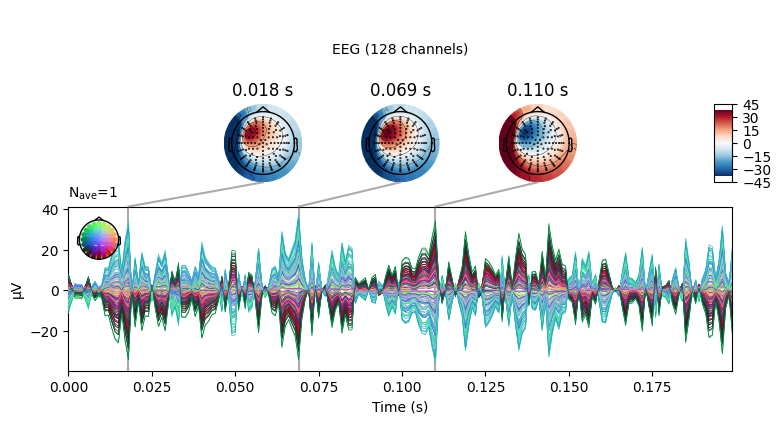

In [5]:
settings = dict(
    number_of_sources=4,
    extents=(1, 26),
    duration_of_trial=0.2,
    amplitudes=(0.1, 100),
    target_snr=1e99)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

stc.data /= abs(stc.data).max()
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

# Solve

In [6]:
from invert import Solver
solver = Solver("MNE")
solver.make_inverse_operator(fwd, evoked, alpha=0)
stc_ = solver.apply_inverse_operator(evoked)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info)
evoked_.plot_joint()

from scipy.stats import pearsonr
pearsonr(abs(stc.data[:, 0]), abs(stc_.data[:, 0]))[0]

c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


No projector specified for this dataset. Please consider the method self.add_proj.


0.556547252554309

Using control points [0.0162757  0.02038939 0.27635033]
Using control points [0.         0.         0.30844946]
Using control points [0.0162757  0.02038939 0.27635033]


# Big Loop

In [5]:
from invert import Solver
# from invert.config import all_solvers
from invert.evaluate import nmse, corr, eval_mean_localization_error, eval_auc
from invert.adapters import contextualize_bd
import pickle as pkl


all_solvers = [ "MNE", "wMNE", "dSPM", "FISTA", "L1L2",
                "LORETA", "sLORETA", "eLORETA", 
                "LAURA", "Backus-Gilbert", 
                "S-MAP",
                "Champagne", "Multiple Sparse Priors", "Bayesian LORETA", "Bayesian MNE", "Bayesian Beamformer", "Bayesian Beamformer LORETA",
                "BCS", "Gamma-MAP", "Source-MAP", "Gamma-MAP-MSP", "Source-MAP-MSP",
                "MVAB", "LCMV", "SMV", "WNMV", "HOCMV", "ESMV", "MCMV", "ESMCMV", "ReciPSIICOS", "SAM",
                # "Fully-Connected", 
                # "LUCAS",
                # "OMP", "COSAMP", "SOMP", "REMBO", "SP", "SSP",
                # "SMP", "SSMP", "SubSMP",
                "EPIFOCUS",
                "MUSIC", "RAP-MUSIC", "TRAP-MUSIC", "JAZZ-MUSIC",
            ]
redo_solvers = np.array(["Champagne", "Multiple Sparse Priors", 
            "Bayesian LORETA", "Bayesian MNE", "Bayesian Beamformer", 
            "Bayesian Beamformer LORETA", "Gamma-MAP", "Source-MAP"])

settings = dict(
    number_of_sources=(1, 8), 
    extents=(1, 35), 
    duration_of_trial=0.01, 
    target_snr=1e99)
alpha = 1e-6

errors_corr = {sname: [] for sname in all_solvers}
errors_mle = {sname: [] for sname in all_solvers}
errors_auc = {sname: [] for sname in all_solvers}
errors_nmse = {sname: [] for sname in all_solvers}

solvers = dict()
sim = Simulation(fwd, info, settings).simulate(10)
    
for i in range(sim.n_samples):
    print(i)
    stc = sim.source_data[i]
    evoked = sim.eeg_data[i].average()

    for solver_name in all_solvers :
        print(solver_name)
        solver = Solver(solver=solver_name)
        if (not solver_name in solvers) or solver_name in redo_solvers:
            if solver_name == "Fully-Connected":
                solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha=alpha, settings=dict(duration_of_trial=0., target_snr=settings["target_snr"], extents=settings["extents"]), n_simulations=5000)
            else:
                solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha=alpha)
        # stc_hat.plot(**pp, brain_kwargs=dict(title=solver.name))
        # error = np.mean(corr(stc.data, stc_hat.data))
        
        try:
            stc_hat = solvers[solver_name].apply_inverse_operator(evoked)
            error_corr = np.mean(corr(stc.data, stc_hat.data))

            error_mle = eval_mean_localization_error(stc.data[:, 0], stc_hat.data[:, 0], pos)
            error_auc = eval_auc(stc.data[:, 0], stc_hat.data[:, 0], pos)
            error_nmse = np.median(nmse(stc.data, stc_hat.data))

        except:
            print("\t...didnt work this time")
            error_mle = np.nan
            error_auc = np.nan
            error_corr = np.nan
            error_nmse = np.nan

        errors_corr[solver_name].append( error_corr )
        errors_mle[solver_name].append( error_mle )
        errors_auc[solver_name].append( error_auc )
        errors_nmse[solver_name].append( error_nmse )

        # Stampc:
        # if not solver_name + "_stampc" in errors_corr.keys():
        #     print("recreating")
        #     errors_corr[solver_name + "_stampc"] = []
        #     errors_mle[solver_name + "_stampc"] = []
        #     errors_auc[solver_name + "_stampc"] = []
        #     errors_nmse[solver_name + "_stampc"] = []
        # try:
        #     stc_hat_stamp = stampc(stc_hat, evoked, fwd, n_orders=1, rv_thresh=0.1)

        #     error_corr = np.mean(corr(stc.data, stc_hat_stamp.data))
        #     error_mle = eval_mean_localization_error(stc.data[:, 0], stc_hat_stamp.data[:, 0], pos)
        #     error_auc = eval_auc(stc.data[:, 0], stc_hat_stamp.data[:, 0], pos)
        #     error_nmse = np.median(nmse(stc.data, stc_hat_stamp.data))
        # except:
        #     error_mle = np.nan
        #     error_auc = np.nan
        #     error_corr = np.nan
        #     error_nmse = np.nan
        # errors_corr[solver_name + "_stampc"].append( error_corr )
        # errors_mle[solver_name + "_stampc"].append( error_mle )
        # errors_auc[solver_name + "_stampc"].append( error_auc )
        # errors_nmse[solver_name + "_stampc"].append( error_nmse )
        
        # print(error_corr, error_mle, error_auc)

    # print("Saving errors")
    # fn = "errors.pkl"
    # with open(fn, 'wb') as f:
    #     pkl.dump([errors_corr, errors_mle, errors_auc, errors_nmse, sim.simulation_info], f)

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 10/10 [00:00<00:00, 10027.02it/s]


source data shape:  (1284, 10) (1284, 10)


100%|██████████| 10/10 [00:00<00:00, 344.65it/s]


0
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
FISTA
L1L2
LORETA
sLORETA
eLORETA
LAURA
Backus-Gilbert
S-MAP
Champagne
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
BCS
Gamma-MAP
Source-MAP
Gamma-MAP-MSP
Source-MAP-MSP
MVAB
LCMV
SMV
WNMV
HOCMV
ESMV
MCMV
ESMCMV
ReciPSIICOS
SAM
EPIFOCUS
MUSIC
RAP-MUSIC
TRAP-MUSIC
JAZZ-MUSIC
1
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
FISTA
L1L2
LORETA
sLORETA
eLORETA
LAURA
Backus-Gilbert
S-MAP
Champagne
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
BCS
Gamma-MAP
Source-MAP
Gamma-MAP-MSP
Source-MAP-MSP
MVAB
LCMV
SMV
WNMV
HOCMV
ESMV
MCMV
ESMCMV
ReciPSIICOS
SAM
EPIFOCUS
MUSIC
RAP-MUSIC
TRAP-MUSIC
JAZZ-MUSIC
2
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
FISTA
L1L2
LORETA
sLORETA
eLORETA
LAURA
Backus-Gilbert
S-MAP
Champagne
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
BCS
Gamma-MAP
Source-MAP
Gamma-MAP-MSP
Source-MAP-MSP
MVAB
LCMV
SMV
WNMV
HOCMV
ESMV
MCMV
ESMCMV
ReciPSIICOS
SAM
EPIFOCUS
MUSIC
RAP-MUSIC
TRAP-MUSIC
JAZZ-MUSIC
3
MNE
wMNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


dSPM
FISTA
L1L2
LORETA
sLORETA
eLORETA
LAURA
Backus-Gilbert
S-MAP
Champagne
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
BCS
Gamma-MAP
Source-MAP
Gamma-MAP-MSP
Source-MAP-MSP
MVAB
LCMV
SMV
WNMV
HOCMV
ESMV
MCMV
ESMCMV
ReciPSIICOS
SAM
EPIFOCUS
MUSIC
RAP-MUSIC
TRAP-MUSIC
JAZZ-MUSIC
4
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
FISTA
L1L2
LORETA
sLORETA
eLORETA
LAURA
Backus-Gilbert
S-MAP
Champagne
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
BCS
Gamma-MAP
Source-MAP
Gamma-MAP-MSP
Source-MAP-MSP
MVAB
LCMV
SMV
WNMV
HOCMV
ESMV
MCMV
ESMCMV
ReciPSIICOS
SAM
EPIFOCUS
MUSIC
RAP-MUSIC
TRAP-MUSIC
JAZZ-MUSIC
5
MNE
wMNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


dSPM
FISTA


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\Users\Lukas\Documents\projects\invert\dev\..\invert\evaluate\evaluate.py:13: RuntimeWarning: invalid value encountered in divide
  error[i] = np.mean(((y_true_slice/abs(y_true_slice).max()) - (y_pred_slice/abs(y_pred_slice).max()))**2)


L1L2
LORETA
sLORETA
eLORETA
LAURA
Backus-Gilbert
S-MAP
Champagne
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
BCS
Gamma-MAP
Source-MAP
Gamma-MAP-MSP
Source-MAP-MSP
MVAB
LCMV
SMV
WNMV
HOCMV
ESMV
MCMV
ESMCMV
ReciPSIICOS
SAM
EPIFOCUS
MUSIC
RAP-MUSIC
TRAP-MUSIC
JAZZ-MUSIC
6
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
FISTA
L1L2
LORETA
sLORETA
eLORETA
LAURA
Backus-Gilbert
S-MAP
Champagne
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
BCS
Gamma-MAP
Source-MAP
Gamma-MAP-MSP
Source-MAP-MSP
MVAB
LCMV
SMV
WNMV
HOCMV
ESMV
MCMV
ESMCMV
ReciPSIICOS
SAM
EPIFOCUS
MUSIC
RAP-MUSIC
TRAP-MUSIC
JAZZ-MUSIC
7
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
FISTA
L1L2
LORETA
sLORETA
eLORETA
LAURA
Backus-Gilbert
S-MAP
Champagne
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
BCS
Gamma-MAP
Source-MAP
Gamma-MAP-MSP
Source-MAP-MSP
MVAB
LCMV
SMV
WNMV
HOCMV
ESMV
MCMV
ESMCMV
ReciPSIICOS
SAM
EPIFOCUS
MUSIC
RAP-MUSIC
TRAP-MUSIC
JAZZ-MUSIC
8
MNE
wMNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


dSPM
FISTA
L1L2
LORETA
sLORETA
eLORETA
LAURA
Backus-Gilbert
S-MAP
Champagne
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
BCS
Gamma-MAP
Source-MAP
Gamma-MAP-MSP
Source-MAP-MSP
MVAB
LCMV
SMV
WNMV
HOCMV
ESMV
MCMV
ESMCMV
ReciPSIICOS
SAM
EPIFOCUS
MUSIC
RAP-MUSIC
TRAP-MUSIC
JAZZ-MUSIC


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\util\util.py:88: RuntimeWarning: invalid value encountered in double_scalars
  area = (s*(s-AB)*(s-AC)*(s-CB)) ** 0.5


9
MNE
wMNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


dSPM
FISTA
L1L2
LORETA
sLORETA
eLORETA
LAURA
Backus-Gilbert
S-MAP
Champagne
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
BCS
Gamma-MAP
Source-MAP
Gamma-MAP-MSP
Source-MAP-MSP
MVAB
LCMV
SMV
WNMV
HOCMV
ESMV
MCMV
ESMCMV
ReciPSIICOS
SAM
EPIFOCUS
MUSIC
RAP-MUSIC
TRAP-MUSIC
JAZZ-MUSIC


In [ ]:
# import pickle as pkl
# fn = "errors.pkl"
# with open(fn, 'rb') as f:
#     errors_corr, errors_mle, errors_auc = pkl.load(f)

In [ ]:
# for key, val in errors_mle.items():
#     errors_mle[key] = val[:31]

# for key, val in errors_corr.items():
#     errors_mle[key] = val[:31]

# for key, val in errors_auc.items():
#     errors_mle[key] = val[:31]
    

# Plot

In [9]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=0.8)

# df = pd.DataFrame(errors_corr)
# df = pd.DataFrame(errors_mle)
# df = pd.DataFrame(errors_auc)
df = pd.DataFrame(errors_nmse)

sorted_index = df.median().sort_values().index
df = df[sorted_index]

plt.figure()
sns.boxplot(data=df)
plt.title("Correlation with ground truth")


df_mean_var = pd.concat([df.mean(), df.std()], axis=1)
df_mean_var = df_mean_var.rename(columns={0: "Median", 1: "Variance"})
df_mean_var["MedVar"] = df_mean_var["Median"] / df_mean_var["Variance"]
df_mean_var["Method"] = df_mean_var.index
df_mean_var = df_mean_var.sort_values(by="Median")
display(df_mean_var)

plt.figure()
sns.scatterplot(x="Median", y="Variance", hue="Method", size="MedVar", data=df_mean_var)
plt.xlabel("Median")
plt.ylabel("Variance")


,Median,Variance,MedVar,Method
Champagne,0.004399,0.004199,1.047476,Champagne
L1L2,0.005139,0.004198,1.224012,L1L2
Source-MAP,0.005700,0.004072,1.399903,Source-MAP
BCS,0.005805,0.004514,1.286028,BCS
JAZZ-MUSIC,0.006030,0.005505,1.095333,JAZZ-MUSIC
RAP-MUSIC,0.006383,0.005023,1.270682,RAP-MUSIC
TRAP-MUSIC,0.006385,0.004955,1.288461,TRAP-MUSIC
LAURA,0.006814,0.003890,1.751692,LAURA
ReciPSIICOS,0.006874,0.004922,1.396562,ReciPSIICOS
Gamma-MAP,0.006905,0.005940,1.162483,Gamma-MAP


Text(0, 0.5, 'Variance')

In [ ]:
settings = dict(number_of_sources=3, extents=(25, 35), duration_of_trial=0.025, target_snr=99999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)